# Spark入门导读
Apache Spark 是当今最流行的开源大数据处理框架。和人们耳熟能详的 MapReduce 一样，Spark 用于进行分布式、大规模的数据处理，但 Spark 作为 MapReduce 的接任者，提供了更高级的编程接口、更高的性能。除此之外，Spark 不仅能进行常规的批处理计算，还提供了流式计算支持，图计算能力以及机器学习的支持。
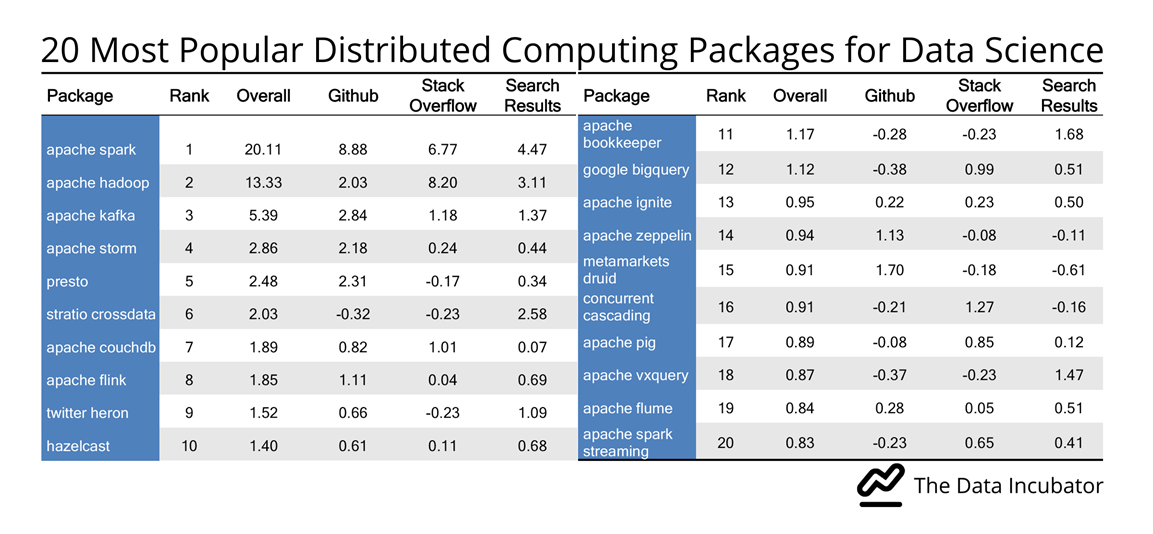

Apache Spark 诞生于大名鼎鼎的 AMPLab（这里还诞生过 Mesos 和 Alluxio），从创立之初就带有浓厚的学术气质，其设计目标是为各种大数据处理需求提供一个统一的技术栈。如今 Spark 背后的商业公司 Databricks 创始人也是来自 AMPLab 的博士毕业生。

Spark 本身使用 Scala 语言编写，Scala 是一门融合了面向对象与函数式的 “双范式” 语言，运行在 JVM 之上。Spark 大量使用了它的函数式、即时代码生成等特性。Spark 目前提供了 Java、Scala、Python、R 四种语言的 API，前两者因为同样运行在 JVM 上可以达到更原生的支持。

## MapReduce 的问题所在

Hadoop 是大数据处理领域的开创者。严格来说，Hadoop 不只是一个软件，而是一整套生态系统，例如 MapReduce 负责进行分布式计算，而 HDFS 负责存储大量文件。

MapReduce 模型的诞生是大数据处理从无到有的飞跃。但随着技术的进步，对大数据处理的需求也变得越来越复杂，MapReduce 的问题也日渐凸显。通常，我们将 MapReduce 的输入和输出数据保留在 HDFS 上，很多时候，复杂的 ETL、数据清洗等工作无法用一次 MapReduce 完成，所以需要将多个 MapReduce 过程连接起来：
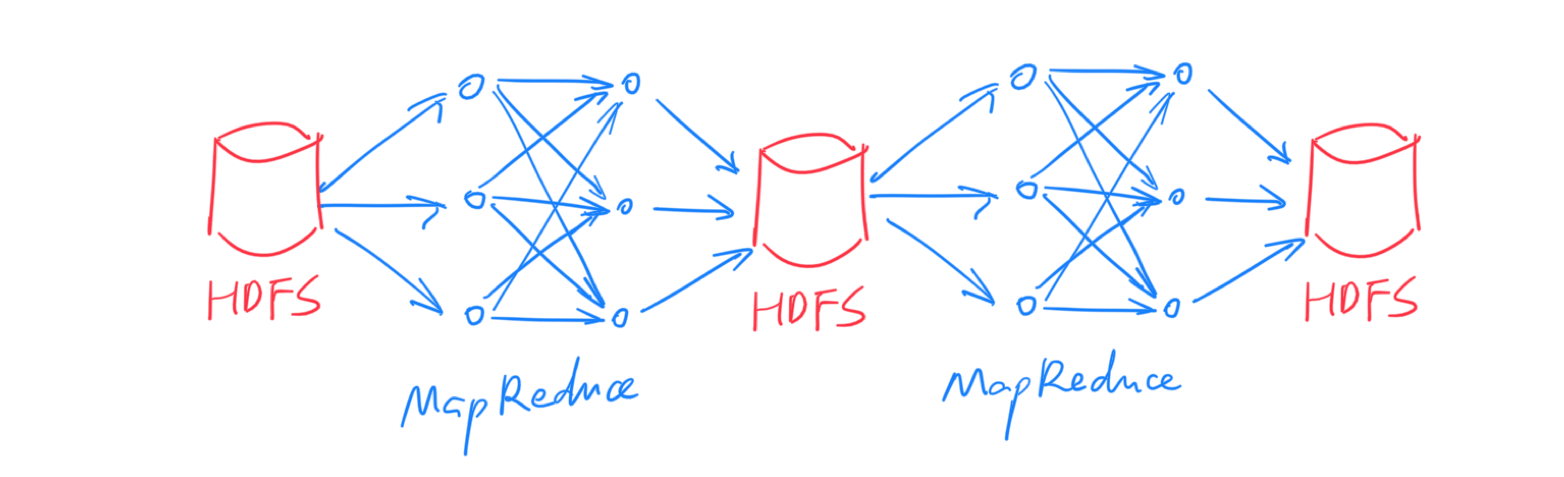
▲ 上图中只有两个 MapReduce 串联，实际上可能有几十个甚至更多，依赖关系也更复杂。


这种方式下，每次中间结果都要写入 **HDFS 落盘保存，代价很大**（别忘了，HDFS 的每份数据都需要冗余若干份拷贝）。另外，由于本质上是多次 MapReduce 任务，调度也比较麻烦，实时性无从谈起。

虽然spark很早2010年就已经出现了，但是yarn的出现给了Spark替代MapReduce的契机：
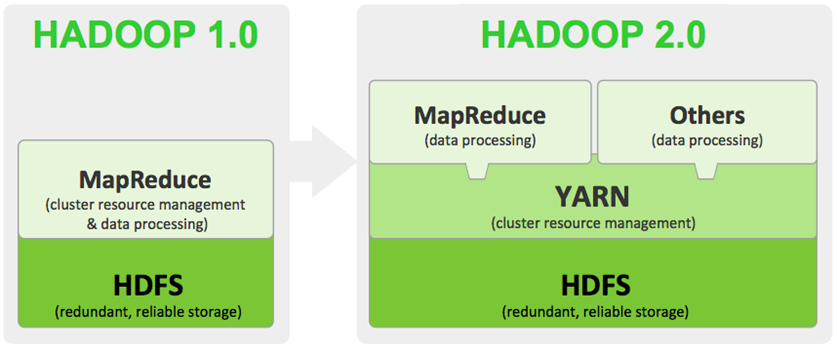

## Spark 与 RDD 模型
针对上面的问题，如果能把中间结果保存在内存里，岂不是快的多？之所以不能这么做，最大的障碍是：分布式系统必须能容忍一定的故障，所谓 fault-tolerance。如果只是放在内存中，一旦某个计算节点宕机，其他节点无法恢复出丢失的数据，只能重启整个计算任务，这对于动辄成百上千节点的集群来说是不可接受的。

一般来说，想做到 fault-tolerance 只有两个方案：
1. 要么存储到外部（例如 HDFS），
2. 要么拷贝到多个副本。

Spark 大胆地提出了第三种——**重算一遍**。但是之所以能做到这一点，是依赖于一个额外的假设：**所有计算过程都是确定性的（deterministic）**。Spark 借鉴了函数式编程思想，提出了 RDD（Resilient Distributed Datasets），译作 “弹性分布式数据集”。
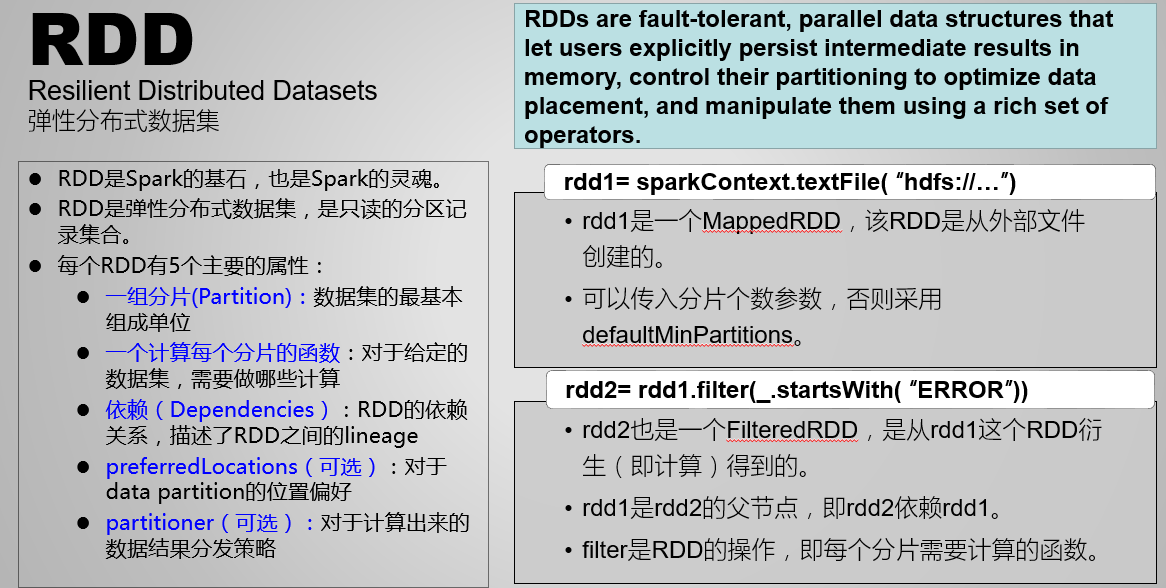


RDD 是一个只读的、分区的（partitioned）数据集合。RDD 要么来源于不可变的外部文件（例如 HDFS 上的文件），要么由确定的算子由其他 RDD 计算得到。RDD 通过算子连接构成有向无环图（DAG），下图演示了一个简单的例子，其中节点对应 RDD，边对应算子。
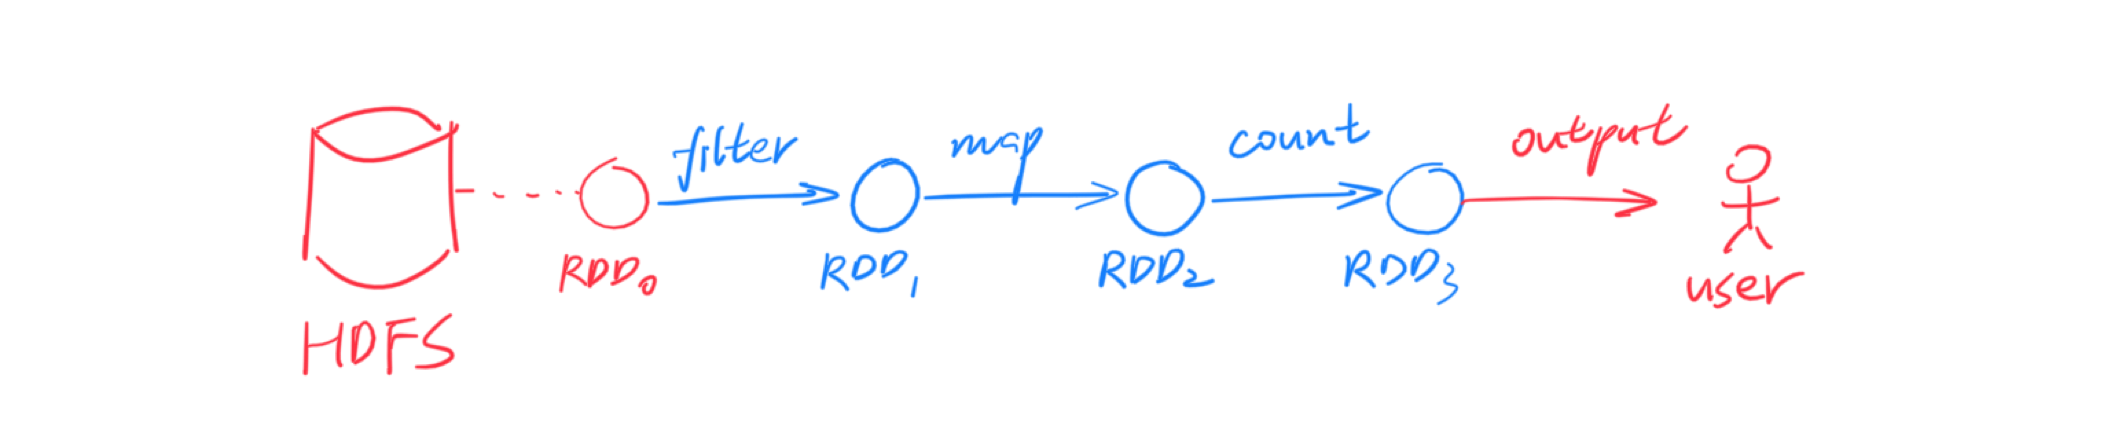

回到刚刚的问题，RDD 如何做到 fault-tolerance？很简单，RDD 中的每个分区都能被确定性的计算出来，所以一旦某个分区丢失了，另一个计算节点可以从它的前继节点出发、用同样的计算过程重算一次，即可得到完全一样的 RDD 分区。这个过程可以递归的进行下去。

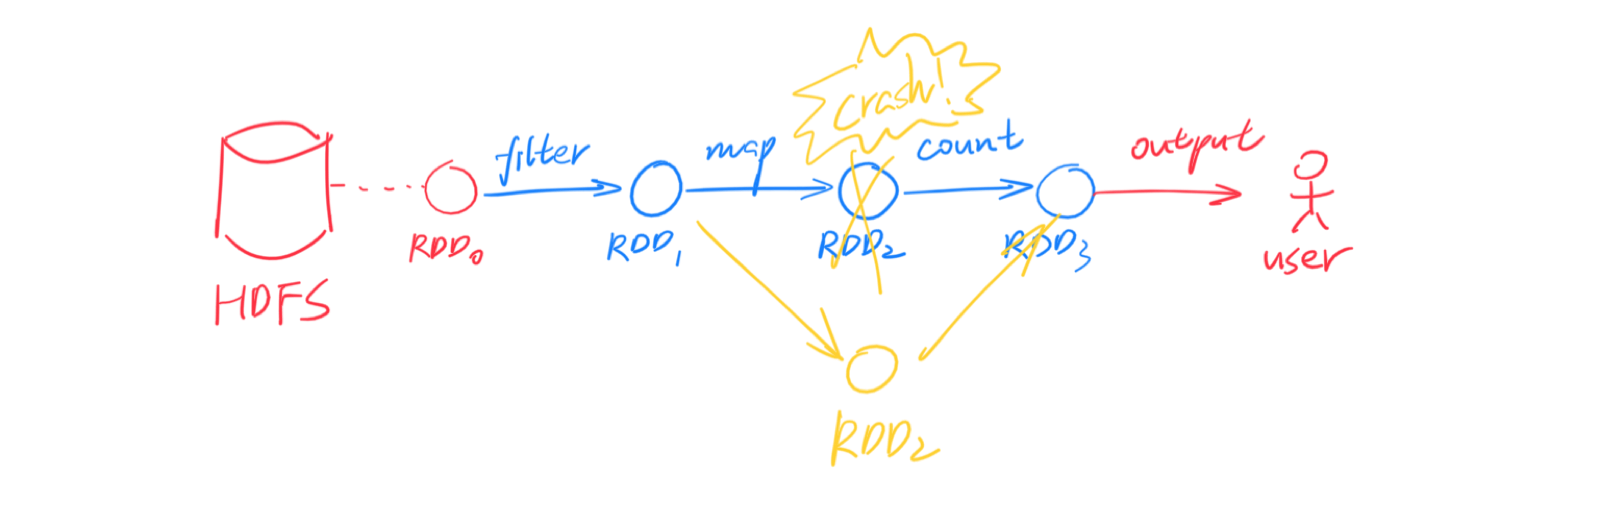

Spark 的编程接口和 Java 8 的 Stream 很相似：RDD 作为数据，在多种算子间变换，构成对执行计划 DAG 的描述。最后，一旦遇到类似 collect() 这样的输出命令，执行计划会被发往 Spark 集群、开始计算。不难发现，算子分成两类：

- map()、filter()、join() 等算子称为 Transformation，它们输入一个或多个 RDD，输出一个 RDD。
- collect()、count()、save() 等算子称为 Action，它们通常是将数据收集起来返回；
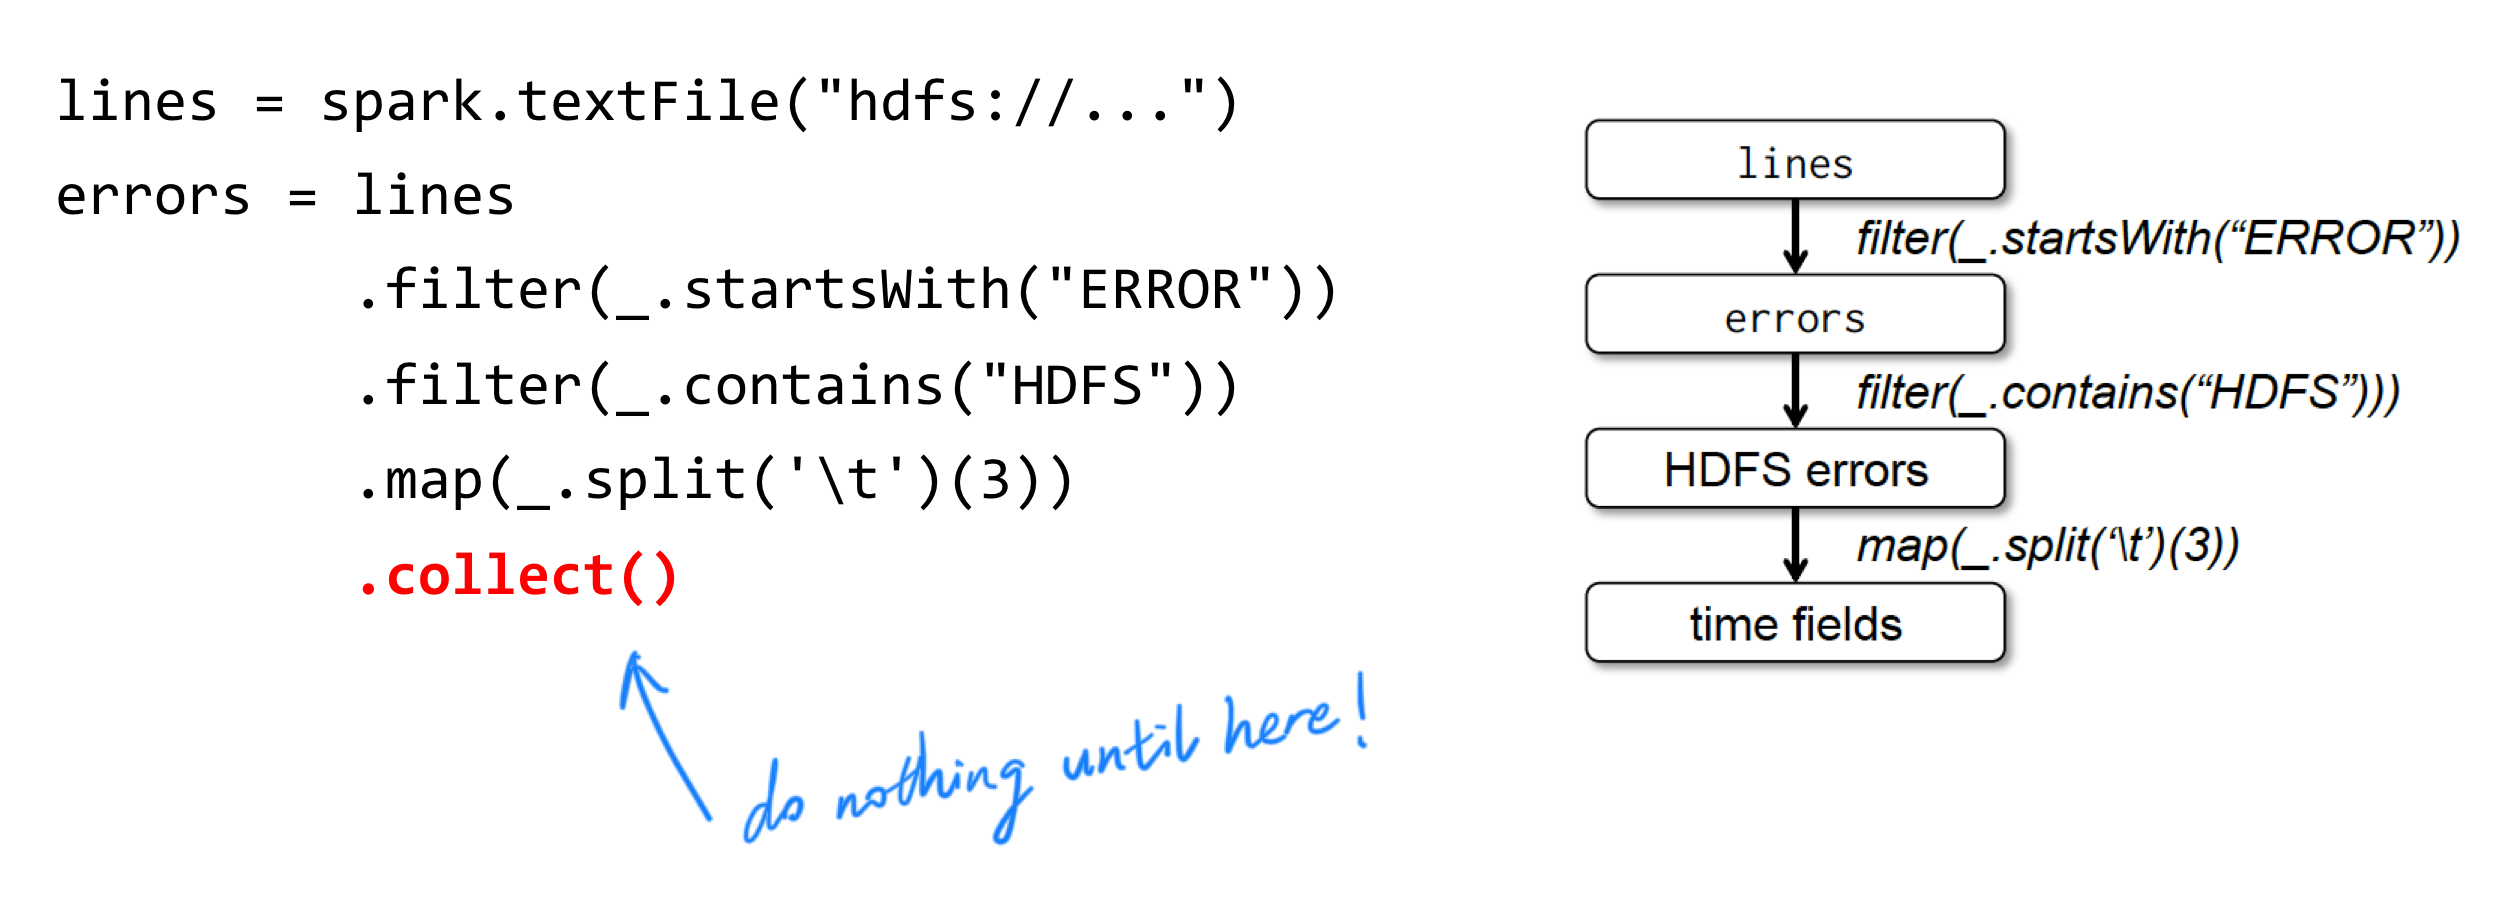

像之前提到的，RDD 的数据由多个分区（partition）构成，这些分区可以分布在集群的各个机器上，这也就是 RDD 中 “distributed” 的含义。熟悉 DBMS 的同学可以把 RDD 理解为逻辑执行计划，partition 理解为物理执行计划。

此外，RDD 还包含它的每个分区的依赖分区（dependency），以及一个函数指出如何计算出本分区的数据。Spark 的设计者发现，依赖关系依据执行方式的不同可以很自然地分成两种：窄依赖（Narrow Dependency）和宽依赖（Wide Dependency），举例来说：

- map()、filter() 等算子构成窄依赖：生产的每个分区只依赖父 RDD 中的一个分区。
- groupByKey() 等算子构成宽依赖：生成的每个分区依赖父 RDD 中的多个分区（往往是全部分区）。

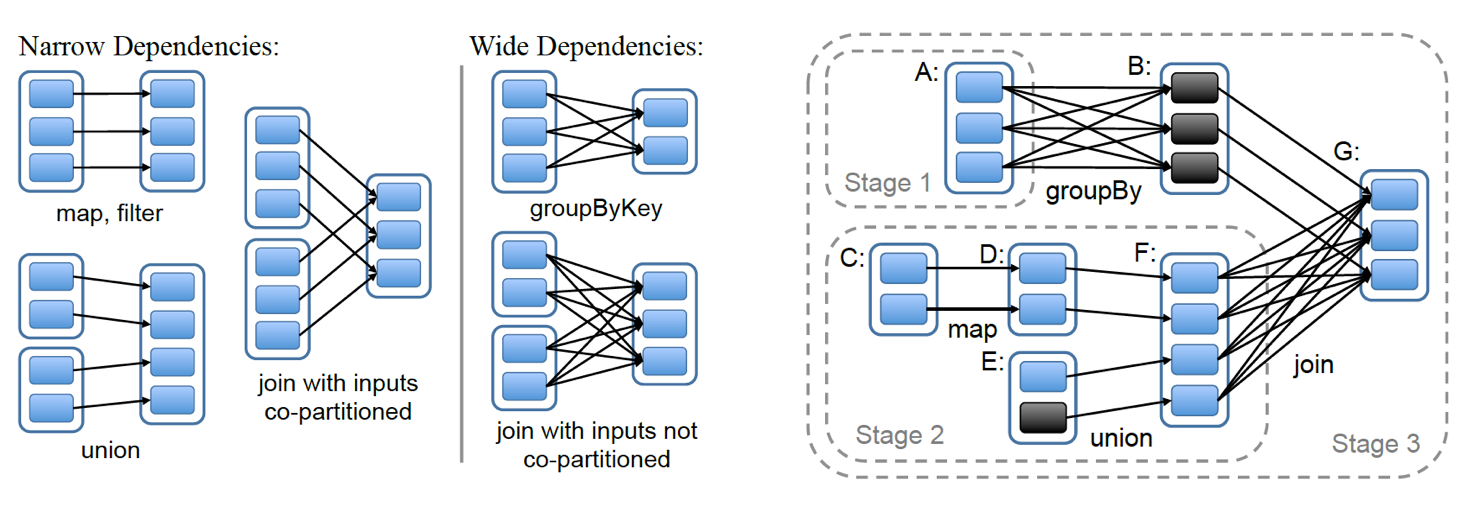
在执行时，窄依赖可以很容易的按流水线（pipeline）的方式计算：对于每个分区从前到后依次代入各个算子即可。然而，宽依赖需要等待前继 RDD 中所有分区计算完成；换句话说，宽依赖就像一个栅栏（barrier）会阻塞到之前的所有计算完成。整个计算过程被宽依赖分割成多个阶段（stage），如上右图所示。

    了解 MapReduce 的同学可能已经发现，宽依赖本质上就是一个 MapReduce 过程。但是相比 MapReduce 自己写 Map 和 Reduce 函数的编程接口，Spark 的接口要容易的多；并且在 Spark 中，多个阶段的 MapReduce 只需要构造一个 DAG 即可。